In [134]:
import pandas as pd
import numpy as np

In [135]:
df = pd.read_csv('../result/result_max_per_gene_single.csv')
df

,Unnamed: 0,dbeta,gene
0,cg00134295,0.207143,A2M
1,cg15769388,-0.143162,A2ML1
2,cg13001012,-0.056940,AADAC
3,cg00150882,0.157614,AADAT
4,cg20940607,0.009114,AAGAB
...,...,...,...
7853,cg07135797,-0.288723,ZNRD1
7854,cg20080983,-0.261198,ZNRF3
7855,cg14231297,0.401591,ZSCAN18
7856,cg14642833,-0.018417,ZWINT


In [136]:
# filter out genes with absolute value of dbeta > 0.35
df_filter = df.loc[df['dbeta'].abs() > 0.35]
df_filter

,Unnamed: 0,dbeta,gene
42,cg13670057,0.359170,ABL1
64,cg10266490,0.403402,ACOT11
65,cg10976772,0.365513,ACOT7
86,cg18770350,0.375086,ACTN2
94,cg09499849,0.383661,ACVR1
...,...,...,...
7762,cg04738965,0.408686,ZIC1
7764,cg16768018,0.462100,ZIC4
7765,cg20985450,0.402938,ZIC5
7827,cg21183523,0.381336,ZNF521


In [137]:
train = pd.read_csv('../champ_result/all_beta_normalized.csv')

In [138]:
df_gene = train[train['Unnamed: 0'].isin(df_filter['Unnamed: 0'])]
df_gene.reset_index(drop=True, inplace=True)
print(df_gene.shape)
df_gene.head()

(388, 891)


,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
0,cg03520644,0.229817,0.229817,0.079642,0.079642,0.180363,0.180363,0.182330,0.182330,0.156993,...,0.787966,0.787966,0.717043,0.717043,0.732963,0.732963,0.653539,0.653539,0.324511,0.324511
1,cg05047401,0.291908,0.291908,0.030616,0.030616,0.219142,0.219142,0.228138,0.228138,0.164601,...,0.790363,0.790363,0.774816,0.774816,0.738141,0.738141,0.780185,0.780185,0.721786,0.721786
2,cg06355129,0.232184,0.232184,0.261523,0.261523,0.176360,0.176360,0.253273,0.253273,0.083640,...,0.913858,0.913858,0.757479,0.757479,0.796541,0.796541,0.798998,0.798998,0.744522,0.744522
3,cg07790615,0.029336,0.029336,0.031738,0.031738,0.052790,0.052790,0.075713,0.075713,0.052144,...,0.793958,0.793958,0.713349,0.713349,0.809180,0.809180,0.798897,0.798897,0.584788,0.584788
4,cg09106903,0.091505,0.091505,0.066134,0.066134,0.126135,0.126135,0.094016,0.094016,0.039025,...,0.726509,0.726509,0.795497,0.795497,0.632736,0.632736,0.779592,0.779592,0.643527,0.643527


In [139]:
train_normal = df_gene.iloc[:,1:94:2]
train_tumor = df_gene.iloc[:,94::2]

train_tumor.columns=range(0,train_tumor.shape[1])
train_normal.columns=range(0,train_normal.shape[1])

train_tumor = train_tumor.T
train_normal = train_normal.T 

In [140]:
train_normal_avg = train_normal.mean(skipna=True, axis=0)

In [141]:
tt_dbeta=(train_tumor).subtract(train_normal_avg, axis = 1) 
tn_dbeta=(train_normal).subtract(train_normal_avg, axis = 1)

In [142]:
train_sensitivity = pd.DataFrame()
train_specificity = pd.DataFrame()
for i in np.arange(0.01,1,0.01):
    cp = i.__round__(2)
    TP = (tt_dbeta.abs() > cp).sum()
    FN = (tt_dbeta.abs() < cp).sum()
    FP = (tn_dbeta.abs() > cp).sum()
    TN = (tn_dbeta.abs() < cp).sum()
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    train_sensitivity = pd.concat([train_sensitivity, sensitivity], ignore_index=True, axis=1)
    train_specificity = pd.concat([train_specificity, specificity], ignore_index=True, axis=1)        

In [143]:
# Youden Index (J)
Approach_J = train_sensitivity + train_specificity - 1 
max_columns_J = Approach_J.idxmax(axis=1)
max_values_J = Approach_J.max(axis=1)

sen_J = train_sensitivity.melt().loc[max_columns_J.index].iloc[:,1]
spe_J = train_specificity.melt().loc[max_columns_J.index].iloc[:,1]

In [144]:
# Concordance Probability Method (CZ)
Approach_CZ = train_sensitivity * train_specificity
max_columns_CZ = Approach_CZ.idxmax(axis=1)
max_values_CZ = Approach_CZ.max(axis=1)

sen_CZ = train_sensitivity.melt().loc[max_columns_CZ.index].iloc[:,1]
spe_CZ = train_specificity.melt().loc[max_columns_CZ.index].iloc[:,1]

In [145]:
# Closest to (0,1) Criteria (ER)
Approach_ER = ((1-train_sensitivity)**2 + (1-train_specificity)**2)
Approach_ER = Approach_ER.apply(np.sqrt)
min_columns_ER = Approach_ER.idxmin(axis=1)
min_values_ER = Approach_ER.min(axis=1)

sen_ER = train_sensitivity.melt().loc[min_columns_ER.index].iloc[:,1]
spe_ER = train_specificity.melt().loc[min_columns_ER.index].iloc[:,1]

In [146]:
from numpy import trapz
train_AUC = trapz(y = train_sensitivity[:], x = train_specificity[:] - 1 ,axis=1)

In [147]:
# F1 score
Approach_F1 = 2 * train_sensitivity * train_specificity / (train_sensitivity + train_specificity)
max_columns_F1 = Approach_F1.idxmax(axis=1)
max_values_F1 = Approach_F1.max(axis=1)

sen_F1 = train_sensitivity.melt().loc[max_columns_F1.index].iloc[:,1]
spe_F1 = train_specificity.melt().loc[max_columns_F1.index].iloc[:,1]

In [148]:
result_df = pd.DataFrame({
        'J': max_values_J, 
        'J cut-point': (max_columns_J+1)/100, 
        'J sensitivity': sen_J, 
        'J specificity': spe_J, 
        'CZ': max_values_CZ,
        'CZ cut-point': (max_columns_CZ+1)/100,
        'CZ sensitivity': sen_CZ,
        'CZ specificity': spe_CZ,
        'ER': min_values_ER,
        'ER cut-point': (min_columns_ER+1)/100,
        'ER sensitivity': sen_ER,
        'ER specificity': spe_ER,
        'F1': max_values_F1,
        'F1 cut-point': (max_columns_F1+1)/100,
        'F1 sensitivity': sen_F1,
        'F1 specificity': spe_F1,
        'AUC': train_AUC
    })
result_df

,J,J cut-point,J sensitivity,J specificity,CZ,CZ cut-point,CZ sensitivity,CZ specificity,ER,ER cut-point,ER sensitivity,ER specificity,F1,F1 cut-point,F1 sensitivity,F1 specificity,AUC
0,0.872180,0.16,0.997494,0.106383,0.872180,0.16,0.997494,0.106383,0.124636,0.15,0.997494,0.106383,0.931727,0.16,0.997494,0.106383,0.854743
1,0.893510,0.25,1.000000,0.063830,0.895323,0.25,1.000000,0.063830,0.087829,0.25,1.000000,0.063830,0.945676,0.25,1.000000,0.063830,0.915827
2,0.840879,0.12,0.984962,0.106383,0.843812,0.12,0.984962,0.106383,0.131504,0.10,0.984962,0.106383,0.916749,0.12,0.984962,0.106383,0.838026
3,0.854637,0.12,0.979950,0.212766,0.854637,0.12,0.979950,0.212766,0.143299,0.06,0.979950,0.212766,0.921622,0.12,0.979950,0.212766,0.737135
4,0.764464,0.11,0.977444,0.106383,0.772676,0.11,0.977444,0.106383,0.197618,0.11,0.977444,0.106383,0.875820,0.11,0.977444,0.106383,0.793393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.819549,0.20,0.994987,0.042553,0.819549,0.20,0.994987,0.042553,0.161058,0.17,0.994987,0.042553,0.900826,0.20,0.994987,0.042553,0.890071
384,0.798272,0.14,0.982456,0.127660,0.802112,0.14,0.982456,0.127660,0.180526,0.13,0.982456,0.127660,0.892091,0.14,0.982456,0.127660,0.800005
385,0.869674,0.19,0.992481,0.127660,0.869674,0.19,0.992481,0.127660,0.114771,0.17,0.992481,0.127660,0.930727,0.17,0.992481,0.127660,0.826214
386,0.682984,0.22,0.972431,0.021277,0.689276,0.22,0.972431,0.021277,0.266849,0.11,0.972431,0.021277,0.819112,0.22,0.972431,0.021277,0.835200


In [149]:
# optional
# result_df.to_csv('../result/result_max_per_gene_single_cp_0.4.csv', index=False)

In [150]:
test = pd.read_csv('../champ_result/all_beta_normalized_test.csv')

In [151]:
df_gene = test[test['Unnamed: 0'].isin(df_filter['Unnamed: 0'])]
df_gene.reset_index(drop=True, inplace=True)
print(df_gene.shape)
df_gene.head()

(388, 901)


,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
0,cg03520644,0.292910,0.292910,0.251303,0.251303,0.259736,0.259736,0.220520,0.220520,0.226304,...,0.620474,0.620474,0.587984,0.587984,0.725763,0.725763,0.543097,0.543097,0.627478,0.627478
1,cg05047401,0.504081,0.504081,0.562472,0.562472,0.537165,0.537165,0.482329,0.482329,0.297942,...,0.773014,0.773014,0.681243,0.681243,0.699969,0.699969,0.720280,0.720280,0.715946,0.715946
2,cg06355129,0.266061,0.266061,0.203968,0.203968,0.346129,0.346129,0.484779,0.484779,0.140203,...,0.222561,0.222561,0.729291,0.729291,0.815345,0.815345,0.728010,0.728010,0.208163,0.208163
3,cg07790615,0.101333,0.101333,0.053834,0.053834,0.111712,0.111712,0.213167,0.213167,0.044492,...,0.702896,0.702896,0.742537,0.742537,0.722355,0.722355,0.619104,0.619104,0.588905,0.588905
4,cg09106903,0.192771,0.192771,0.218550,0.218550,0.222275,0.222275,0.105394,0.105394,0.136350,...,0.701276,0.701276,0.531955,0.531955,0.759788,0.759788,0.750459,0.750459,0.119129,0.119129


In [152]:
test_normal = df_gene.iloc[:,2:102:2]
test_tumor = df_gene.iloc[:,102::2]

test_tumor.columns=range(0,test_tumor.shape[1])
test_normal.columns=range(0,test_normal.shape[1])

test_tumor = test_tumor.T
test_normal = test_normal.T 

In [153]:
# Computing IQR
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence=Q3+IQR*1.5
    lower_fence=Q1-IQR*1.5
    return upper_fence,lower_fence
def no_outlier(df):
    upper_fence,lower_fence=IQR(df)
    ddf=df[(df>lower_fence)&(df<upper_fence)]
    return ddf

In [155]:
test_normal_avg = test_normal.mean(skipna=True, axis=0)

In [156]:
ttt_dbeta=(test_tumor).subtract(test_normal_avg, axis = 1)
ttn_dbeta=(test_normal).subtract(test_normal_avg, axis = 1)

In [157]:
cp_list = ['J cut-point', 'CZ cut-point', 'ER cut-point', 'F1 cut-point']
df_cpc = result_df[cp_list]
test_cp_sensitivity = pd.DataFrame()
test_cp_specificity = pd.DataFrame()

for i in range(0, df_cpc.shape[1]):
    cp = df_cpc[cp_list[i]]
    TP = (ttt_dbeta.abs() > cp).sum()
    FN = (ttt_dbeta.abs() < cp).sum()
    FP = (ttn_dbeta.abs() > cp).sum()
    TN = (ttn_dbeta.abs() < cp).sum()
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    test_cp_sensitivity = pd.concat([test_cp_sensitivity, sensitivity], ignore_index=True, axis=1)
    test_cp_specificity = pd.concat([test_cp_specificity, specificity], ignore_index=True, axis=1)
    
test_cp_sensitivity.columns = cp_list
test_cp_specificity.columns = cp_list

In [158]:
test_sensitivity = pd.DataFrame()
test_specificity = pd.DataFrame()
for i in np.arange(0.01,1,0.01):
    cp = i.__round__(2)
    TP = (ttt_dbeta.abs() > cp).sum()
    FN = (ttt_dbeta.abs() < cp).sum()
    FP = (ttn_dbeta.abs() > cp).sum()
    TN = (ttn_dbeta.abs() < cp).sum()
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    test_sensitivity = pd.concat([test_sensitivity, sensitivity], ignore_index=True, axis=1)
    test_specificity = pd.concat([test_specificity, specificity], ignore_index=True, axis=1)  

In [159]:
from numpy import trapz
test_AUC = trapz(y = test_sensitivity[:], x = test_specificity[:], axis=1)
test_AUC.shape

(388,)

In [160]:
print(test_cp_sensitivity.shape)
test_cp_sensitivity.head(6)

(388, 4)


,J cut-point,CZ cut-point,ER cut-point,F1 cut-point
0,0.9000,0.9000,0.9125,0.9000
1,0.8150,0.8150,0.8150,0.8150
2,0.8825,0.8825,0.8950,0.8825
3,0.8600,0.8600,0.8850,0.8600
4,0.8075,0.8075,0.8075,0.8075
5,0.6475,0.6475,0.9075,0.6475


In [161]:
print(test_cp_specificity.shape)
test_cp_specificity.head(6)

(388, 4)


,J cut-point,CZ cut-point,ER cut-point,F1 cut-point
0,0.94,0.94,0.94,0.94
1,0.86,0.86,0.86,0.86
2,0.82,0.82,0.78,0.82
3,0.90,0.90,0.82,0.90
4,0.88,0.88,0.88,0.88
5,0.88,0.88,0.24,0.88


In [162]:
import numpy as np
def J_method(sen, spe):
    J = sen + spe - 1
    return J
def CZ_method(sen, spe):
    CZ = sen * spe 
    return CZ
def ER_method(sen, spe):
    ER = (1-sen)**2 + (1-spe)**2
    ER = ER.apply(np.sqrt)
    return ER
def UI_method(sen, spe, auc):
    UI = abs(sen.subtract(auc, axis=0)) + abs(spe.subtract(auc, axis=0))
    return UI
def F1_method(sen, spe):
    F1 = 2 * sen * spe / (sen + spe)
    return F1

In [163]:
J = J_method(test_cp_sensitivity, test_cp_specificity)
CZ = CZ_method(test_cp_sensitivity, test_cp_specificity)
ER = ER_method(test_cp_sensitivity, test_cp_specificity)
F1 = F1_method(test_cp_sensitivity, test_cp_specificity)

In [164]:
df_cross_validation = pd.concat([J, CZ, ER,F1],keys = ['J', 'CZ', 'ER','F1'], axis=1)
# merge two level of columns
df_cross_validation.columns = df_cross_validation.columns.map(','.join)
df_cross_validation.columns = df_cross_validation.columns.str.replace(' cut-point', '')
print(df_cross_validation.shape)
df_cross_validation.head()

(388, 16)


,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER","CZ,F1","ER,J","ER,CZ","ER,ER","ER,F1","F1,J","F1,CZ","F1,ER","F1,F1"
0,0.8400,0.8400,0.8525,0.8400,0.84600,0.84600,0.85775,0.84600,0.116619,0.116619,0.106095,0.116619,0.919565,0.919565,0.926046,0.919565
1,0.6750,0.6750,0.6750,0.6750,0.70090,0.70090,0.70090,0.70090,0.232002,0.232002,0.232002,0.232002,0.836896,0.836896,0.836896,0.836896
2,0.7025,0.7025,0.6750,0.7025,0.72365,0.72365,0.69810,0.72365,0.214956,0.214956,0.243772,0.214956,0.850103,0.850103,0.833552,0.850103
3,0.7600,0.7600,0.7050,0.7600,0.77400,0.77400,0.72570,0.77400,0.172047,0.172047,0.213600,0.172047,0.879545,0.879545,0.851261,0.879545
4,0.6875,0.6875,0.6875,0.6875,0.71060,0.71060,0.71060,0.71060,0.226840,0.226840,0.226840,0.226840,0.842193,0.842193,0.842193,0.842193


In [165]:
method_list = ['J','CZ','ER','F1']
for i in method_list:
    ascending = False
    if i == 'ER':
        ascending = True
    for j in method_list:
        df_cross_validation[f'{i},{j}_rank'] = df_cross_validation[f'{i},{j}'].rank(ascending=ascending)

In [166]:
df_filter.reset_index(drop=True, inplace=True)
df_cross_validation = pd.concat([df_filter, df_cross_validation], axis=1)
df_cross_validation = pd.concat([df_cross_validation, pd.DataFrame(train_AUC, columns=['train_AUC'])], axis=1)
df_cross_validation = pd.concat([df_cross_validation, pd.DataFrame(test_AUC, columns=['test_AUC'])], axis=1)
df_cross_validation

,Unnamed: 0,dbeta,gene,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER",...,"ER,J_rank","ER,CZ_rank","ER,ER_rank","ER,F1_rank","F1,J_rank","F1,CZ_rank","F1,ER_rank","F1,F1_rank",train_AUC,test_AUC
0,cg13670057,0.359170,ABL1,0.8400,0.8400,0.8525,0.8400,0.84600,0.84600,0.85775,...,27.0,27.0,16.0,28.0,36.0,36.0,24.0,35.0,0.854743,0.826275
1,cg10266490,0.403402,ACOT11,0.6750,0.6750,0.6750,0.6750,0.70090,0.70090,0.70090,...,230.0,230.0,210.0,227.0,243.0,243.0,221.0,240.0,0.915827,0.828800
2,cg10976772,0.365513,ACOT7,0.7025,0.7025,0.6750,0.7025,0.72365,0.72365,0.69810,...,202.0,204.0,231.5,204.0,215.0,215.0,230.5,211.0,0.838026,0.812100
3,cg18770350,0.375086,ACTN2,0.7600,0.7600,0.7050,0.7600,0.77400,0.77400,0.72570,...,114.0,115.0,184.0,113.0,130.0,131.0,188.0,129.0,0.737135,0.833275
4,cg09499849,0.383661,ACVR1,0.6875,0.6875,0.6875,0.6875,0.71060,0.71060,0.71060,...,226.0,225.0,203.0,222.0,232.0,232.0,210.0,229.0,0.793393,0.794525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,cg04738965,0.408686,ZIC1,0.7925,0.7925,0.8025,0.7925,0.79625,0.79625,0.80880,...,148.0,152.0,88.0,155.0,109.0,108.0,70.0,104.0,0.890071,0.844150
384,cg16768018,0.462100,ZIC4,0.7375,0.7375,0.7475,0.7375,0.74965,0.74965,0.75905,...,194.0,196.0,157.0,195.0,185.0,183.0,144.0,179.0,0.800005,0.723775
385,cg20985450,0.402938,ZIC5,0.7725,0.7725,0.6675,0.6675,0.78540,0.78540,0.68970,...,95.0,96.0,246.0,267.0,114.0,113.0,239.0,264.0,0.826214,0.903850
386,cg21183523,0.381336,ZNF521,0.6225,0.6225,0.4425,0.6225,0.64630,0.64630,0.50995,...,329.0,329.0,358.0,325.0,319.0,319.0,361.0,317.0,0.835200,0.727975


In [167]:
# calculate correlation between J,J	and J,CZ
J_cor = [
    df_cross_validation['J,J'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,J'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,J'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,J'].corr(df_cross_validation['J,F1'])]
CZ_cor = [
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,F1'])]
ER_cor = [
    df_cross_validation['J,ER'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,ER'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,ER'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,ER'].corr(df_cross_validation['J,F1'])]
F1_cor = [
    df_cross_validation['J,F1'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,F1'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,F1'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,F1'].corr(df_cross_validation['J,F1'])]

 
J_cor += J_cor[:1]
CZ_cor += CZ_cor[:1]
ER_cor += ER_cor[:1]
F1_cor += F1_cor[:1]

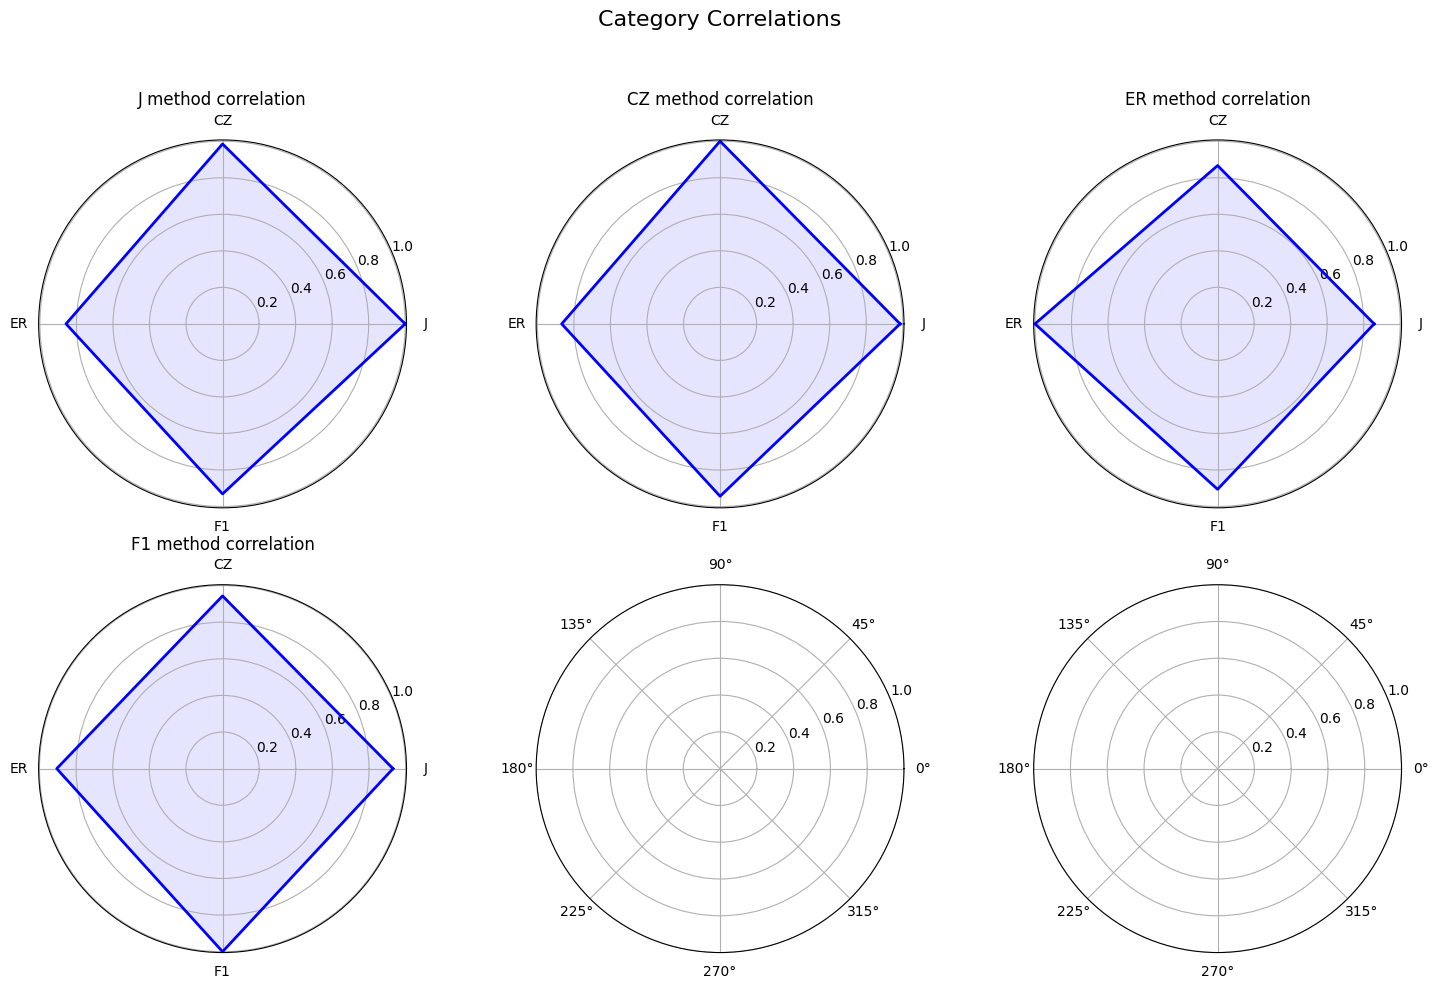

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the five categories

categories = ['J', 'CZ', 'ER', 'F1']
num_categories = len(categories)
# Create an array of evenly spaced angles to represent each category
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]

# Create a figure with 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(polar=True))
fig.suptitle('Category Correlations', fontsize=16)

# Loop through the categories and create subplots
for i, (ax, category) in enumerate(zip(axes.flatten(), categories)):
    
    ax.fill(angles, eval(f'{category}_cor'), 'b', alpha=0.1)
    ax.plot(angles, eval(f'{category}_cor'), 'b', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(f'{category} method correlation')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


In [169]:
print(df_cross_validation.shape)
df_cross_validation

(388, 37)


,Unnamed: 0,dbeta,gene,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER",...,"ER,J_rank","ER,CZ_rank","ER,ER_rank","ER,F1_rank","F1,J_rank","F1,CZ_rank","F1,ER_rank","F1,F1_rank",train_AUC,test_AUC
0,cg13670057,0.359170,ABL1,0.8400,0.8400,0.8525,0.8400,0.84600,0.84600,0.85775,...,27.0,27.0,16.0,28.0,36.0,36.0,24.0,35.0,0.854743,0.826275
1,cg10266490,0.403402,ACOT11,0.6750,0.6750,0.6750,0.6750,0.70090,0.70090,0.70090,...,230.0,230.0,210.0,227.0,243.0,243.0,221.0,240.0,0.915827,0.828800
2,cg10976772,0.365513,ACOT7,0.7025,0.7025,0.6750,0.7025,0.72365,0.72365,0.69810,...,202.0,204.0,231.5,204.0,215.0,215.0,230.5,211.0,0.838026,0.812100
3,cg18770350,0.375086,ACTN2,0.7600,0.7600,0.7050,0.7600,0.77400,0.77400,0.72570,...,114.0,115.0,184.0,113.0,130.0,131.0,188.0,129.0,0.737135,0.833275
4,cg09499849,0.383661,ACVR1,0.6875,0.6875,0.6875,0.6875,0.71060,0.71060,0.71060,...,226.0,225.0,203.0,222.0,232.0,232.0,210.0,229.0,0.793393,0.794525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,cg04738965,0.408686,ZIC1,0.7925,0.7925,0.8025,0.7925,0.79625,0.79625,0.80880,...,148.0,152.0,88.0,155.0,109.0,108.0,70.0,104.0,0.890071,0.844150
384,cg16768018,0.462100,ZIC4,0.7375,0.7375,0.7475,0.7375,0.74965,0.74965,0.75905,...,194.0,196.0,157.0,195.0,185.0,183.0,144.0,179.0,0.800005,0.723775
385,cg20985450,0.402938,ZIC5,0.7725,0.7725,0.6675,0.6675,0.78540,0.78540,0.68970,...,95.0,96.0,246.0,267.0,114.0,113.0,239.0,264.0,0.826214,0.903850
386,cg21183523,0.381336,ZNF521,0.6225,0.6225,0.4425,0.6225,0.64630,0.64630,0.50995,...,329.0,329.0,358.0,325.0,319.0,319.0,361.0,317.0,0.835200,0.727975


In [170]:
dmp = pd.read_csv('../champ_result/DMP_result_test.csv')
# remove gene columns
dmp = dmp.drop(dmp.columns[-10], axis=1)

In [171]:
merge = pd.merge(df_cross_validation, dmp, on='Unnamed: 0', how='left')

In [172]:
# drop row with nan in feature
# merge.dropna(subset=['feature'], inplace=True)
merge

,Unnamed: 0,dbeta,gene,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER",...,Type,feature,cgi,feat.cgi,UCSC_CpG_Islands_Name,DHS,Enhancer,Phantom,Probe_SNPs,Probe_SNPs_10
0,cg13670057,0.359170,ABL1,0.8400,0.8400,0.8525,0.8400,0.84600,0.84600,0.85775,...,II,Body,opensea,Body-opensea,NaN,NaN,True,NaN,NaN,NaN
1,cg10266490,0.403402,ACOT11,0.6750,0.6750,0.6750,0.6750,0.70090,0.70090,0.70090,...,II,TSS200,opensea,TSS200-opensea,NaN,NaN,NaN,NaN,NaN,NaN
2,cg10976772,0.365513,ACOT7,0.7025,0.7025,0.6750,0.7025,0.72365,0.72365,0.69810,...,II,Body,opensea,Body-opensea,NaN,True,True,NaN,NaN,NaN
3,cg18770350,0.375086,ACTN2,0.7600,0.7600,0.7050,0.7600,0.77400,0.77400,0.72570,...,I,1stExon,island,1stExon-island,chr1:236849472-236850323,True,True,high-CpG:234916417-234916759,NaN,NaN
4,cg09499849,0.383661,ACVR1,0.6875,0.6875,0.6875,0.6875,0.71060,0.71060,0.71060,...,II,5'UTR,opensea,5'UTR-opensea,NaN,NaN,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,cg04738965,0.408686,ZIC1,0.7925,0.7925,0.8025,0.7925,0.79625,0.79625,0.80880,...,I,1stExon,island,1stExon-island,chr3:147126988-147128999,True,True,NaN,NaN,NaN
384,cg16768018,0.462100,ZIC4,0.7375,0.7375,0.7475,0.7375,0.74965,0.74965,0.75905,...,I,Body,island,Body-island,chr3:147108511-147111703,NaN,NaN,NaN,NaN,NaN
385,cg20985450,0.402938,ZIC5,0.7725,0.7725,0.6675,0.6675,0.78540,0.78540,0.68970,...,I,Body,island,Body-island,chr13:100620241-100624348,NaN,NaN,NaN,NaN,rs61080730
386,cg21183523,0.381336,ZNF521,0.6225,0.6225,0.4425,0.6225,0.64630,0.64630,0.50995,...,II,Body,shore,Body-shore,chr18:22930018-22930904,NaN,NaN,NaN,NaN,NaN


In [173]:
merge.to_csv('../result/result_test_cut_point_cross_vali_dmptest_0.35.csv', index=False)